# [LVV-T2416](https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T2416)
Created by Bruno Quint on 2022.01.10

Determine if the Center of Gravity of ComCam is close to the rotation axis within the tolerance. For this, the notebook uses the Rotator to move ComCam with a slow speed and the total torque should be below 30 N.m. 

This notebook contains the code to execute the test case and analyse the data.

When at **0 deg**, if the sum of the torques is not 0 N.m, then the Center of Gravity is shifted in the **X direction**.   
When near to **+/- 90 deg**, if the sum of the torques is not 0 N.m, then the Center of Gravity is shifted in the **Y direction**.

## Start Up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

/tmp/ipykernel_44800/1665379685.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) get_node. (Please use lsst.rsp.get_node())
  nb.utils.get_node()


'yagan06'

In [3]:
%matplotlib inline
import os
import sys
import asyncio
import logging

import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import os
import pandas as pd

from astropy.time import Time
from scipy.signal import argrelextrema

from lsst.ts import salobj
from lsst.ts.observatory.control.maintel.mtcs import MTCS

In [4]:
summit = 1 #use this for summit testing
# summit = 0 #use this for NCSA

## Helper Functions

### Retrieve EFD Client

First of all, the notebook will have different behavior if we run at the Summit or at the NCSA TestSand (NTS) (or other simulated environments). This function simply wraps this difference.

In [5]:
def retrieve_efd_client(is_at_summit=True):
    """
    Retrieves a client to the Engireering Facility Database. 
    
    Parameters
    ----------
    is_at_summit : bool, optional
        If this notebook runs at the Summit, returns a client that connect to 
        the Summit EFD. Otherwhice, results the NCSA TestSand (NST) EFD.
    
    Returns
    -------
    EfdClient : the interface object between Nublado and the Summit or NST EFD.
    """
    from lsst_efd_client import EfdClient
    
    c = EfdClient('summit_efd') if is_at_summit \
        else EfdClient('ncsa_teststand_efd') 
        
    return c

### Retrieve Data from EFD

Second, we want to analyse the motors torques at different angles. For that, we can either use the Binary Logs generated by the MTRotator EUI or we can get the data directly from the EFD, which is much easier. The following function retrieves the data from the EFD.

In [6]:
async def retrieve_rotator_angle_and_torques_from_efd(client, start, end):
    """
    Retrieves the Rotator Angle and the Motors torques from the EFD.
    
    Parameters
    ----------
    client : EfdClient
        Interface that allows querying data from the EFD.
    start : datetime string
        ISOT Time in UTC associated to the start of the data.
    end : datetime string
        ISOT Time in UTC associated to the end of the data.
        
    Returns
    -------
    _df : DataFrame
        Table containing the queried data.
    """
    _df_rotator = await client.select_time_series(
        'lsst.sal.MTRotator.rotation', 
        fields='actualPosition', 
        start=start, 
        end=end)

    _df_motor1 = await client.select_time_series(
        "lsst.sal.MTRotator.motors", 
        fields='torque0', 
        start=start, 
        end=end)

    _df_motor2 = await client.select_time_series(
        "lsst.sal.MTRotator.motors", 
        fields='torque1', 
        start=start, 
        end=end)

    _df = pd.merge(_df_rotator, _df_motor1, left_index=True, right_index=True)
    _df = pd.merge(_df, _df_motor2, left_index=True, right_index=True)
    _df = _df.dropna()
    
    return _df

### Plot Rotator Angle And Torques

In [7]:
def plot_rotator_angle_and_torques(_df, filename=None):
    """
    Every time that we have the Rotator stopped at a given angle, we have that 
    :math:`\tau_{M1} + \tau_{M2} + \tau_{CM} = 0`. If the center of mass is at 
    the center of the rotation, :math:`\tau_{CM} = 0`, meaning that 
    :math:`\tau_{M1} = - \tau_{M2}`. 
    
    This plot should be used to identify if and when :math:`\tau_{CM} = 0`.
    
    The left y-axis shows the motor torques in N.m while the right y-axis shows 
    the rotator angle in degrees. 
    
    Parameters
    ----------
    _df : DataFrame
    filename : str
    """
    _df = _df.copy()
    _df["torque_sum"] = _df["torque0"] + _df["torque1"]
    
    fig, ax = plt.subplots(
        figsize=(12,6), 
        num=f'Torques and Rotator Position Angle - {filename}')

    ax.plot(_df.index, 
            _df['torque0'].rolling(50).mean(), 
            label='Actual Torque Axis 1')

    ax.plot(_df.index, 
            _df['torque1'].rolling(50).mean(), 
            label='Actual Torque Axis 2')
    
    ax.plot(_df.index, 
            _df['torque_sum'].rolling(50).mean(), 
            label='Actual Torque Axis 2')
    
    ax.set_ylabel('Actual Torque Axis [N.m]')
    ax.set_ylim(-6e-4, 6e-4)
    ax.set_xlabel('Time [UTC]')
    ax.grid(lw=0.5, alpha=0.2)
    ax.ticklabel_format(axis="y", style="sci")
    ax.fmt_xdata = mdates.DateFormatter("%H:%M:S")

    ax2 = ax.twinx()
    ax2.plot(_df.index, _df["torque1"] * 0, 'k', alpha=0.1)
    ax2.fill_between(
        _df.index, 0, _df["actualPosition"], alpha=0.1, 
        fc='k', label='Rotator Position Angle')
    ax2.fmt_xdata = mdates.DateFormatter("%H:%M:S")

    ax2.set_ylabel('Rotator Position Angle [deg]')

    fig.autofmt_xdate()
    fig.legend(loc='lower center', ncol=4, )
    fig.suptitle(f"Torques and Rotator Position Angle\n"
                 f"{_df.index[0].strftime('%Y-%m-%d %H:%M:%S')}")
    
    if filename:
        os.makedirs('plots', exist_ok=True)
        fig.savefig(os.path.join('plots', filename), facecolor='white', dpi=150)
        print(f"Plot file saved to plots/{filename}")
        
    plt.show()

### Plot Torques Vs Rotator Angle

Some people prefer this kind of data visualization. So let's leave it here to complement the data analyzis.

In [8]:
def plot_torque_vs_rotator_angle(_df, filename):
    """
    Plots the motor torques vs the rotation angle, showing a cyclic plot.
    
    Parameters
    ----------
    _df : DataFrame
    filename : str
    """
    fig, ax = plt.subplots(
        figsize=(12,12),
        num=f"Torque Vs Rotator Angle - {filename}",)
        
    _df = _df.copy()
    _df["torque_sum"] = _df["torque0"] + _df["torque1"]
    
    ax.plot(_df["actualPosition"], _df["torque0"], 
            label="Motor 1")
    ax.plot(_df["actualPosition"], _df["torque1"], 
            label="Motor 2")
    ax.plot(_df["actualPosition"], _df["torque_sum"], 
            label="Sum")
    
    ax.set_xlabel('Rotator Angle [deg]')
    ax.set_ylabel('Total Torque [N.m]')
    ax.grid(lw=0.5, alpha=0.2)
    
    fig.legend(loc='lower center', ncol=3, )
    fig.suptitle(f"Torques Vs Rotator Position Angle\n"
                 f"{_df.index[0].strftime('%Y-%m-%d %H:%M:%S')}")
    
    if filename:
        os.makedirs('plots', exist_ok=True)
        fig.savefig(os.path.join('plots', filename), facecolor='white', dpi=150)
        print(f"Plot file saved to plots/{filename}")
        
    plt.show()

### Print Average Torques at given Angle

In [9]:
def get_average_torques_at_angle(_df, angle):
    """ 
    Prints out the average torques at a given rotation angle.
    """
    sub_df = _df[_df['Rotator_Position_deg'].round(1) == angle]
    
    avg_torque_motor1 = sub_df['actual_torque_axis_1'].mean()
    std_torque_motor1 = sub_df['actual_torque_axis_1'].std()
    
    avg_torque_motor2 = sub_df['actual_torque_axis_2'].mean()
    std_torque_motor2 = sub_df['actual_torque_axis_2'].std()
    
    avg_total = avg_torque_motor1 + avg_torque_motor2
    std_total = std_torque_motor1 + std_torque_motor2
    sin = np.sin(np.deg2rad(angle))
    
    print(
        f"Average Torques at {angle} deg\n"
        f"Motor 1 = {avg_torque_motor1:.3f} N.m +/- {std_torque_motor1:.3f} N.m\n"
        f"Motor 2 = {avg_torque_motor2:.3f} N.m +/- {std_torque_motor2:.3f} N.m\n"
        f"Total Torque: {avg_total:.3f} N.m +/- {std_total:.3f} N.m\n")

#         f"Total Torque divided by sin(theta): {avg_total / sin:.3f} N.m"
#         f" +/- {std_total / sin:.3f} N.m\n")
    

## Check environment setup

The following cell will print some of the basic DDS configutions.

In [10]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ.get("LSST_DDS_DOMAIN_ID", "Expected, not set."))

file:///home/b1quint/WORK/ts_ddsconfig/config/ospl-shmem.xml
summit
0


### Setup logging

Setup logging in debug mode and create a logger to use on the notebook.

In [ ]:
logging.basicConfig(format="%(name)s:%(message)s", level=logging.DEBUG)

In [ ]:
log = logging.getLogger("setup")
log.level = logging.DEBUG

### Starting communication resources

We start by creating a domain and later instantiate the MTCS class.
We will use the class to startup the components. 

In [ ]:
domain = salobj.Domain()

In [ ]:
mtcs = MTCS(domain=domain, log=log)
mtcs.set_rem_loglevel(40)

In [ ]:
await mtcs.start_task

## Start Test

The default Velocity Limit for the Rotator is 3.5 deg/s.  
Set the Velocity Limit to a low value (e.g. 0.5 deg/s or 0.2 deg/s).

In [ ]:
# Set Velocity Limit to 0.5 deg/s
await mtcs.rem.mtrotator.cmd_configureVelocity.set_start(vlimit=0.5, timeout=5)

----
Move the Rotator from 0 deg to +/- 90 deg in small steps (10 deg).  
Keep an eye on the Motor Currents for Motor1 and Motor2 in the Rotator EUI. They should not exceed 4.2 A.  
If any of the Motor Currents is too close to the limit of 4.2 A, lower down the Velocity Limit.  

In [ ]:
# Move the Rotator to 10 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=10, timeout=5)

In [ ]:
# Move the Rotator to 20 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=20, timeout=5)

In [ ]:
# Move the Rotator to 30 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=30, timeout=5)

In [ ]:
# Move the Rotator to 40 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=40, timeout=5)

In [ ]:
# Move the Rotator to 50 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=50, timeout=5)

In [ ]:
# Move the Rotator to 60 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=60, timeout=5)

In [ ]:
# Move the Rotator to 70 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=70, timeout=5)

In [ ]:
# Move the Rotator to 80 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=80, timeout=5)

In [ ]:
# Move the Rotator to 90 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=90, timeout=5)

If the velocity is sufficiently low to avoid the motor current limit and the envelope space is clear, you can move the Rotator all the way back to 0 deg.

In [ ]:
# Move the Rotator to 0 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)

----
Now, moving the Rotator to the negative side.

In [ ]:
# Move the Rotator to -10 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=-10, timeout=5)

In [ ]:
# Move the Rotator to -20 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=-20, timeout=5)

In [ ]:
# Move the Rotator to -30 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=-30, timeout=5)

In [ ]:
# Move the Rotator to -40 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=-40, timeout=5)

In [ ]:
# Move the Rotator to -50 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=-50, timeout=5)

In [ ]:
# Move the Rotator to -60 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=-60, timeout=5)

In [ ]:
# Move the Rotator to -70 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=-70, timeout=5)

In [ ]:
# Move the Rotator to -80 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=-80, timeout=5)

In [ ]:
# Move the Rotator to -90 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=-90, timeout=5)

If the velocity is sufficiently low to avoid the motor current limit and the envelope space is clear, you can move the Rotator all the way back to 0 deg.

In [ ]:
# Move the Rotator to 0 deg
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)

---
Record the time when the actual test starts for data analysis.

In [ ]:
t_start = Time(Time.now(), scale='utc', format='isot')

Wait a few minutes to have data recorded at 0 deg.  
If the center of mass is aligned with the x-axis, the sum of the torques at 0 degree should be around 0 N.m.   
Check the results later in this notebook.

---
Move the Rotator to 90 deg. 
Wait a few minues to have data recorded at 90 deg.  
If the center of mass is aligned with the y-axis, the sum of the torques at +/- 90 degrees should be around 0 N.m.   
Check the results later in this notebook.

In [ ]:
await mtcs.rem.mtrotator.cmd_move.set_start(position=90, timeout=5)

---
Move the Rotator back to 0 deg.   
Wait a few minutes

In [ ]:
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)

---
Move the Rotator to -90 deg.  
Wait a few minutes.

In [ ]:
await mtcs.rem.mtrotator.cmd_move.set_start(position=-90, timeout=5)

---
Move the Rotator back to 0 deg.   
Wait a few minutes

In [ ]:
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)

### Data Analysis

---
Analyze the data

In [11]:
# t_end = Time(Time.now(), scale='utc', format='isot')
t_start = Time('2021-10-01T14:00:00', scale='utc', format='isot') 
t_end = Time('2021-10-01T14:25:00', scale='utc', format='isot')

In [12]:
efd_client = retrieve_efd_client(summit)
df = await retrieve_rotator_angle_and_torques_from_efd(efd_client, t_start, t_end)

Plot file saved to plots/EFD_20211001_140000.png


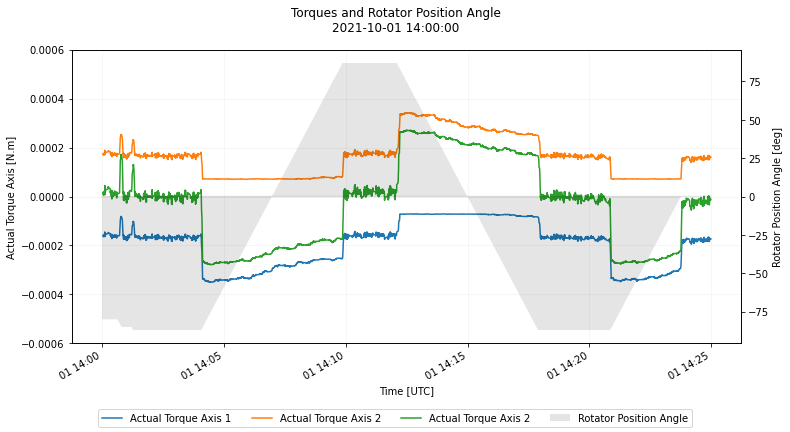

In [13]:
filename = f"EFD_{t_start.strftime('%Y%m%d_%H%M%S')}.png"
plot_rotator_angle_and_torques(df, filename=filename)

Plot file saved to plots/EFD_RotVsTorque_20211001_140000.png


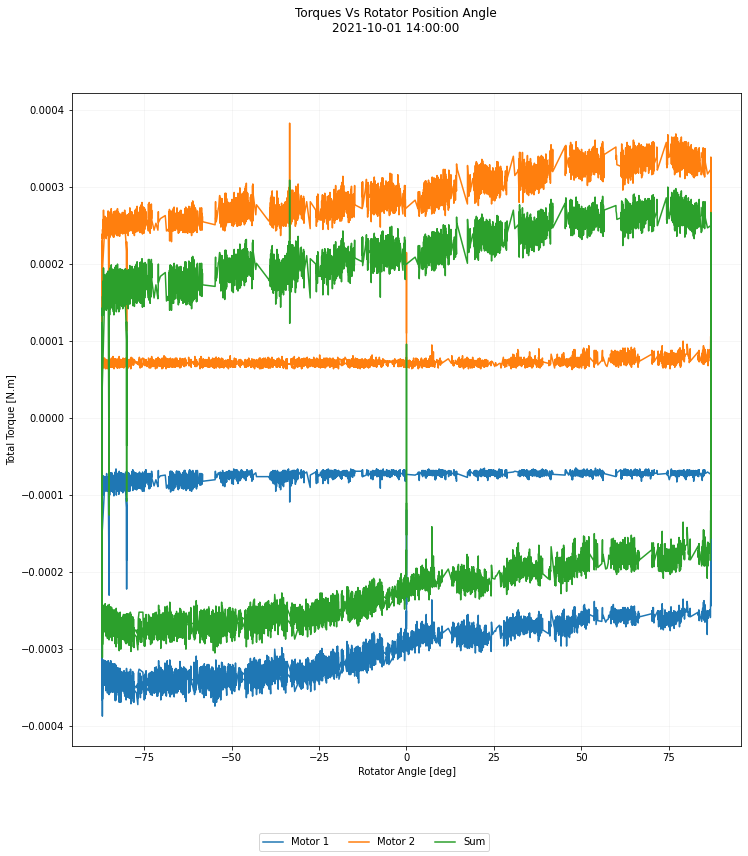

In [14]:
filename = f"EFD_RotVsTorque_{t_start.strftime('%Y%m%d_%H%M%S')}.png"
plot_torque_vs_rotator_angle(df, filename=filename)